In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense

In [2]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          rotation_range = 20)

In [3]:
train_directory = 'Desktop/sports/train'
val_directory = 'Desktop/sports/valid'
test_directory = 'Desktop/sports/test'

In [4]:
train_dataset = data_aug.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),
    subset="training",
    seed=42,
    batch_size=32
)

val_dataset = data_aug.flow_from_directory(
    directory=val_directory,
    target_size=(224, 224),
    seed=42,
    batch_size=32 
)
test_dataset = data_aug.flow_from_directory(
    directory=test_directory,
    target_size=(224, 224),
    seed=42,
    batch_size=32
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [5]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
mobilenet = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet'
)

In [6]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [7]:
mobilenet.trainable = False

In [8]:
model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(640, activation = 'relu'))
model.add(Dense(100, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               64100     
Total params: 3,141,924
Trainable params: 883,940
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
            loss='CategoricalCrossentropy',
            metrics = ['accuracy'])

In [10]:
history = model.fit(train_dataset , validation_data = val_dataset , epochs = 5)

Epoch 1/5
422/422 [==============================] - 1521s 4s/step - loss: 1.3789 - accuracy: 0.6426 - val_loss: 0.6088 - val_accuracy: 0.8100
Epoch 2/5
422/422 [==============================] - 1056s 3s/step - loss: 0.5777 - accuracy: 0.8280 - val_loss: 0.5530 - val_accuracy: 0.8480
Epoch 3/5
422/422 [==============================] - 1041s 2s/step - loss: 0.4116 - accuracy: 0.8717 - val_loss: 0.5307 - val_accuracy: 0.8320
Epoch 4/5
422/422 [==============================] - 1000s 2s/step - loss: 0.3455 - accuracy: 0.8926 - val_loss: 0.3992 - val_accuracy: 0.8700
Epoch 5/5
422/422 [==============================] - 992s 2s/step - loss: 0.2601 - accuracy: 0.9191 - val_loss: 0.4644 - val_accuracy: 0.8820


In [12]:
len(mobilenet.layers)

154

In [13]:
for layer in mobilenet.layers[:144]:
    layer.trainable = None

In [14]:
model.compile(loss='CategoricalCrossentropy',
              optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
fine_tune_epochs = 2
total_epochs =  5 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 5/7
422/422 [==============================] - 972s 2s/step - loss: 0.1132 - accuracy: 0.9673 - val_loss: 0.3639 - val_accuracy: 0.8800
Epoch 6/7
422/422 [==============================] - 931s 2s/step - loss: 0.0864 - accuracy: 0.9759 - val_loss: 0.3073 - val_accuracy: 0.9040
Epoch 7/7
422/422 [==============================] - 945s 2s/step - loss: 0.0760 - accuracy: 0.9790 - val_loss: 0.3364 - val_accuracy: 0.8880


In [16]:
model.evaluate(test_dataset)

16/16 [==============================] - 68s 4s/step - loss: 0.2414 - accuracy: 0.9280


[0.24141459167003632, 0.9279999732971191]

In [17]:
predictions = model.predict(test_dataset)
print(predictions)

[[4.7461662e-10 3.4123626e-12 2.4072004e-13 ... 2.6258629e-12
  3.1071059e-07 1.9736350e-13]
 [2.9780244e-07 5.2561067e-09 5.7742006e-13 ... 6.3768150e-11
  6.2060490e-09 1.6775534e-10]
 [5.7214813e-05 2.1194184e-09 8.1705913e-09 ... 1.2994361e-04
  3.6434213e-07 2.8233915e-08]
 ...
 [4.9108916e-08 6.0862832e-04 6.2990723e-05 ... 2.1302177e-11
  3.1477146e-05 5.1869429e-09]
 [3.3730220e-11 1.1456101e-10 1.6689462e-10 ... 5.6417062e-11
  3.4568591e-11 2.9609379e-12]
 [5.1370985e-10 2.2096376e-13 4.5097820e-14 ... 2.0841888e-13
  1.3085686e-08 9.6509606e-11]]


In [19]:
import numpy as np
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

[43 13 65  2 56 62 11 33 65  6 32 89 29 54 60 95 29 13 97 30 25  3 87 84
 56 51 77 77 88 98 93 41 18 52 20  6 26 61 99 53 99 31 72 10 50 89 89 64
 66 38 67 92 35 72 78 16 70 13 15 17 87  1 95 84  3 35 45 67 69 43 47 31
  9 59 32 60 97 91 73 34 69 27 77 75 53 66 75 36 32 90 27 93 16 45 38 14
 14 17 50 39 58 84 15 88 18 78 73 99 24 59 28  6 20 43 15 88  0 18 22 20
 96 51 10 44 44 85 17 54 45 94 59 81  7 98 68 24 94 52 22  3 73 21 19 33
 49 42 68 89 62 26 61 67 65 14 43 80 85 84 53 39 16 42 82 11 16 26 37 27
 65 75 70 86 48 81 83 37 36 55  5 56 19 61 24 53 90 36 74 15 53 77 86 32
 49 55 40  8 19 65 24 51 13 13 85 62 88 54 46 95 91 88 30 68 70 51 54 88
 30 72 98 50  0 25 95 40 18 99 41 50 66 37 58 38 41 40 81 35 20 75 80 64
 46 50 16 19 79 53 26  8 74 40 86 80 98 55  7 31 45 71 21 38 45 35 10 80
  1 28 94 48 75  1 57 58 35  5 96  3 36 59 69 82 72 85 37 18 74 71 26 23
 93 58 83 86 47 34 64  8 98 94 71 66 87 96 49 33 39 60  0 86 25 32 21 46
  4 53 92 68  5 63  7 56  1 64 97 76  6 73 89 27  2

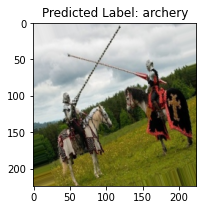

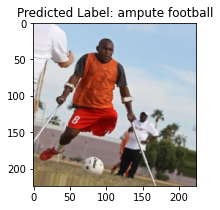

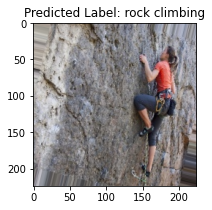

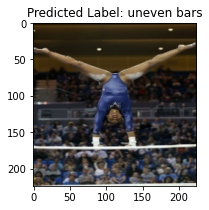

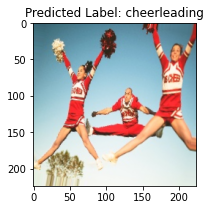

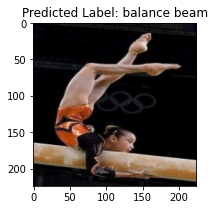

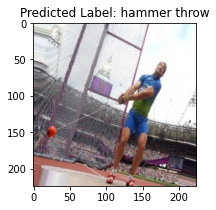

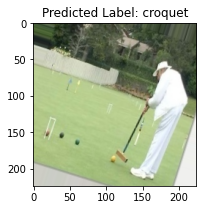

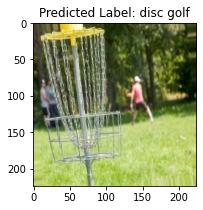

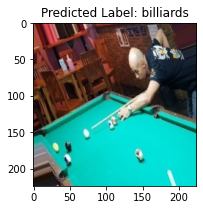

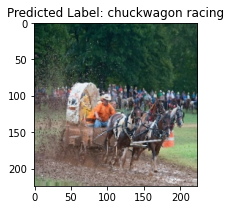

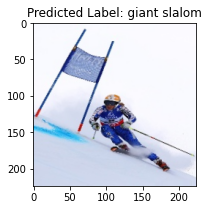

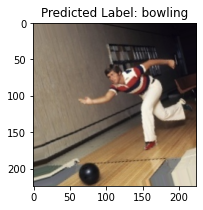

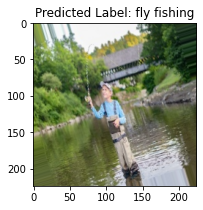

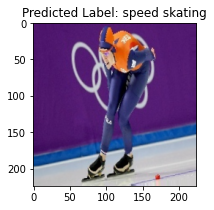

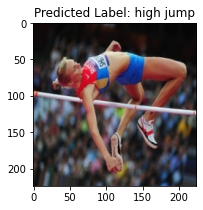

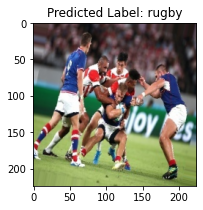

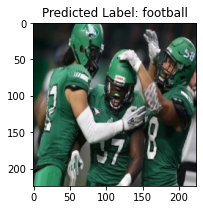

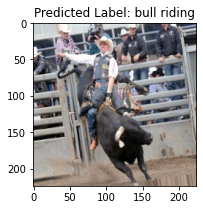

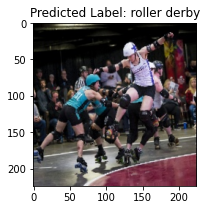

In [22]:
import os

class_labels = sorted(os.listdir(train_directory))

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    for i in range(min(20, len(images))):
        plt.figure(figsize=(3, 3))
        plt.imshow(images[i])
        
        predicted_label = class_labels[predicted_labels[i]]
        
        plt.title(f"Predicted Label: {predicted_label}")
        plt.show()

    break
